In [1]:
import io
import zipfile
import pandas
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

archive_name = 'grenoble_2018-10-09_1811644.zip'
archive = zipfile.ZipFile(archive_name)

def get_csv(archive, filename, newcolumns={}):
    df= pandas.read_csv(io.BytesIO(archive.read(filename)), names=['function', 'm', 'n', 'k', 'start', 'duration'])
    df['size_cube'] = -1
    df.loc[df.function == 'dtrsm', 'size_cube'] = df.m * df.n**2
    df.loc[df.function == 'dgemm', 'size_cube'] = df.m * df.n * df.k
    df['min_size'] = -1
    min_mn  = df[['m', 'n'     ]].min(axis=1)
    min_mnk = df[['m', 'n', 'k']].min(axis=1)
    df.loc[df.function == 'dtrsm', 'min_size'] = min_mn
    df.loc[df.function == 'dgemm', 'min_size'] = min_mnk
    df['max_size'] = df[['m', 'n', 'k']].max(axis=1)
    df['flops'] = df['size_cube'] * 2 / df['duration']
    df['index'] = range(len(df))
    for name, val in newcolumns.items():
        df[name] = val
    return df

def get_op(df, op):
    return df[df.function == op]


result_multicore = get_csv(archive, 'result_multicore.csv')
result_monocore_nocontention = get_csv(archive, 'result_monocore.csv', {'contention': False})
result_monocore_contention = get_csv(archive, 'result_monocore_contention.csv', {'contention': True})
result_monocore = pandas.concat([result_monocore_nocontention, result_monocore_contention])

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


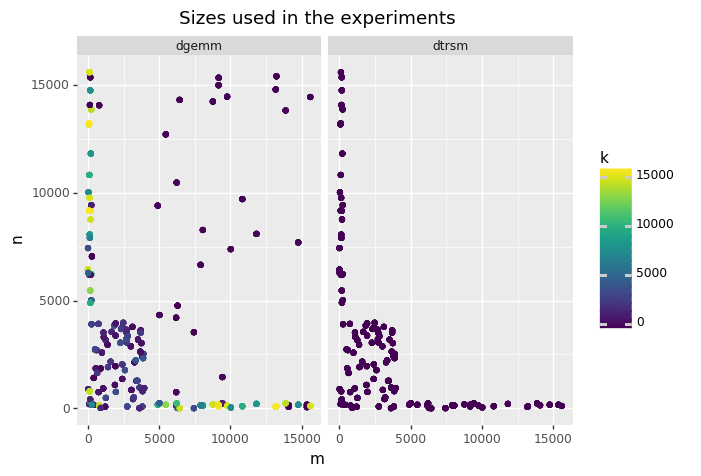

<ggplot: (-9223363259396843162)>

In [2]:
ggplot(result_monocore_contention, aes(x='m', y='n', color='k')) + geom_point() + facet_wrap('function') + ggtitle('Sizes used in the experiments')

## Multicore

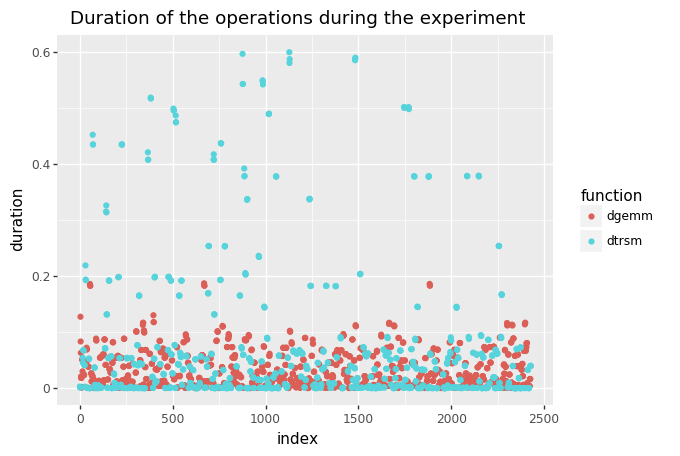

<ggplot: (8777457929564)>

In [3]:
ggplot(result_multicore, aes(x='index', y='duration', color='function')) + geom_point() + ggtitle('Duration of the operations during the experiment')

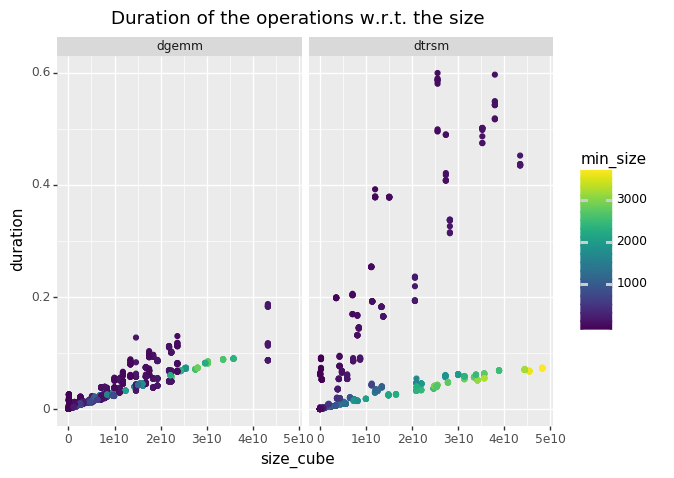

<ggplot: (-9223363259491490770)>

In [4]:
ggplot(result_multicore, aes(x='size_cube', y='duration', color='min_size')) + geom_point() + facet_wrap('function') + ggtitle('Duration of the operations w.r.t. the size')

997.144302061182


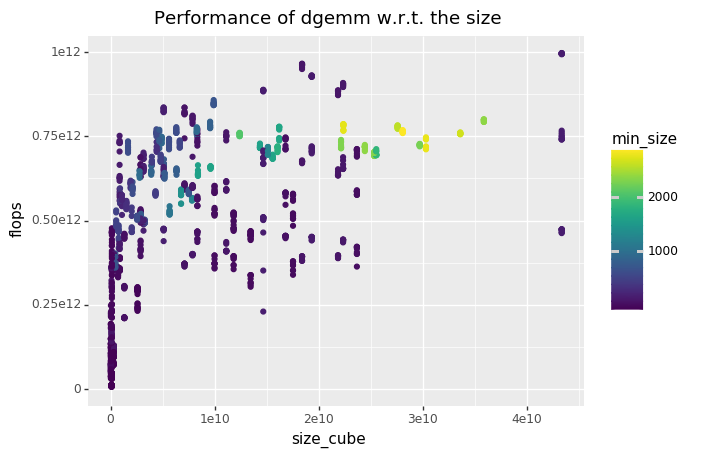

<ggplot: (8777363185293)>

In [5]:
print(get_op(result_multicore, 'dgemm').flops.max()*1e-9)
ggplot(get_op(result_multicore, 'dgemm'), aes(x='size_cube', y='flops', color='min_size')) + geom_point() + expand_limits(y=0) + ggtitle('Performance of dgemm w.r.t. the size')

## Monocore, with and without contention

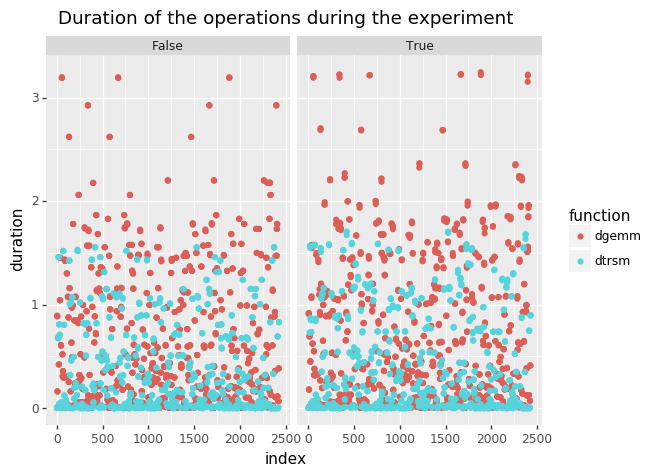

<ggplot: (-9223363259491604371)>

In [6]:
ggplot(result_monocore, aes(x='index', y='duration', color='function')) + geom_point() + facet_wrap('contention') + ggtitle('Duration of the operations during the experiment')

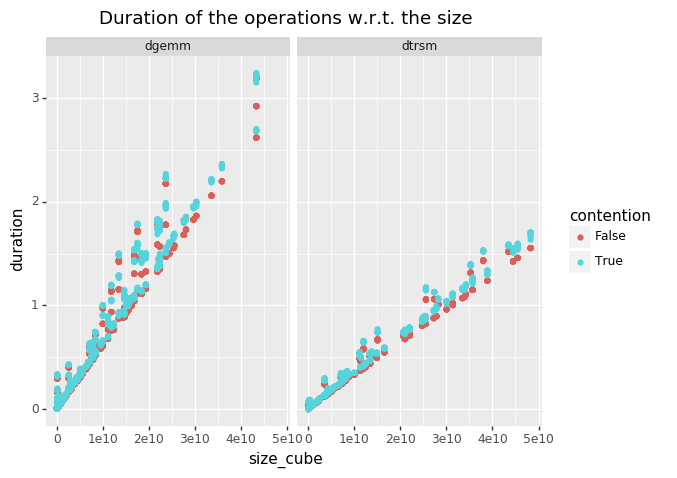

<ggplot: (8777361408797)>

In [7]:
ggplot(result_monocore, aes(x='size_cube', y='duration', color='contention')) + geom_point() + facet_wrap('function') + ggtitle('Duration of the operations w.r.t. the size')

contention
False    33.35520
True     32.41901
Name: flops, dtype: float64


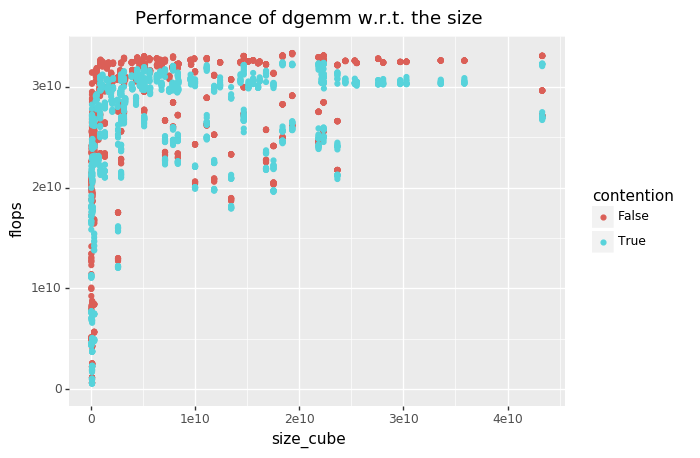

<ggplot: (-9223363259493383855)>

In [8]:
print(get_op(result_monocore, 'dgemm').groupby('contention').flops.max()*1e-9)
ggplot(get_op(result_monocore, 'dgemm'), aes(x='size_cube', y='flops', color='contention')) + geom_point() + expand_limits(y=0) + ggtitle('Performance of dgemm w.r.t. the size')

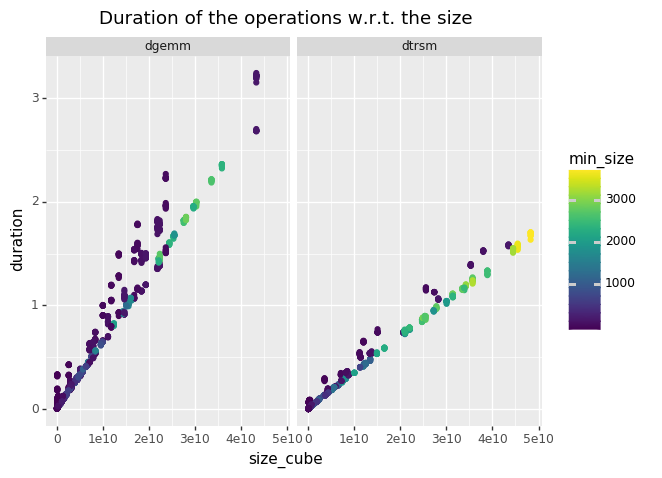

<ggplot: (-9223363259493335843)>

In [9]:
ggplot(result_monocore_contention, aes(x='size_cube', y='duration', color='min_size')) + geom_point() + facet_wrap('function') + ggtitle('Duration of the operations w.r.t. the size')

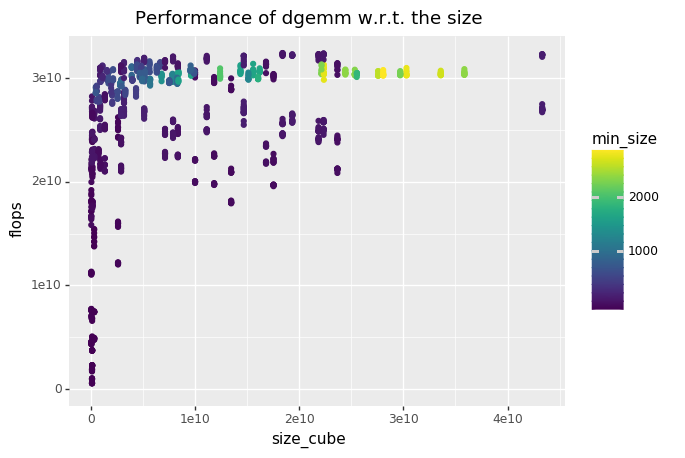

<ggplot: (8777356957837)>

In [10]:
ggplot(get_op(result_monocore_contention, 'dgemm'), aes(x='size_cube', y='flops', color='min_size')) + geom_point() + expand_limits(y=0) + ggtitle('Performance of dgemm w.r.t. the size')

## Regression for the monocore experiment

In [11]:
import statsmodels.formula.api as sm
df_dgemm = get_op(result_monocore, 'dgemm')
df_dgemm = df_dgemm[df_dgemm.contention]
reg_dgemm = sm.ols(data=df_dgemm, formula='duration ~ size_cube').fit()
reg_dgemm.params

Intercept    3.318569e-02
size_cube    6.981328e-11
dtype: float64

intercept  : 3.318569e-02
coefficient: 6.981328e-11


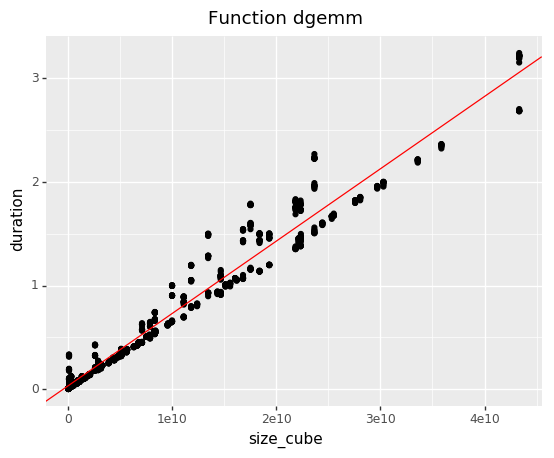

<ggplot: (-9223363259497840489)>

In [12]:
def compute_lm(df):
    reg = sm.ols(data=df, formula='duration ~ size_cube').fit().params
    print('intercept  : %e' % reg['Intercept'])
    print('coefficient: %e' % reg['size_cube'])
    func = df.function.unique()
    assert len(func) == 1
    func = func[0]
    return ggplot(df, aes(x='size_cube', y='duration')) + geom_point() + geom_abline(intercept=reg['Intercept'], slope=reg['size_cube'], color='red') + ggtitle('Function %s' % func)

compute_lm(get_op(result_monocore_contention, 'dgemm'))

intercept  : 1.839709e-02
coefficient: 3.550977e-11


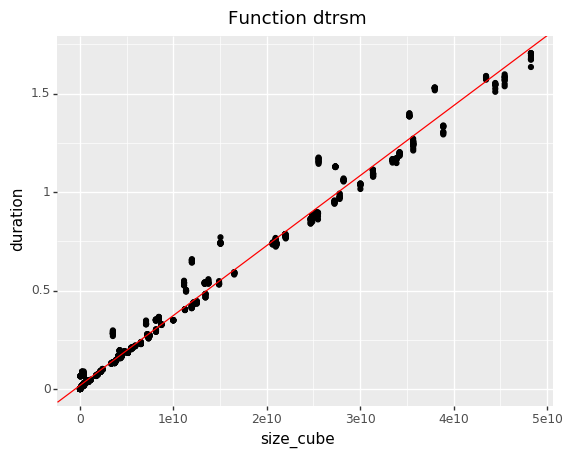

<ggplot: (8777457950910)>

In [13]:
compute_lm(get_op(result_monocore_contention, 'dtrsm'))

intercept  : 1.718005e-02
coefficient: 4.618700e-11


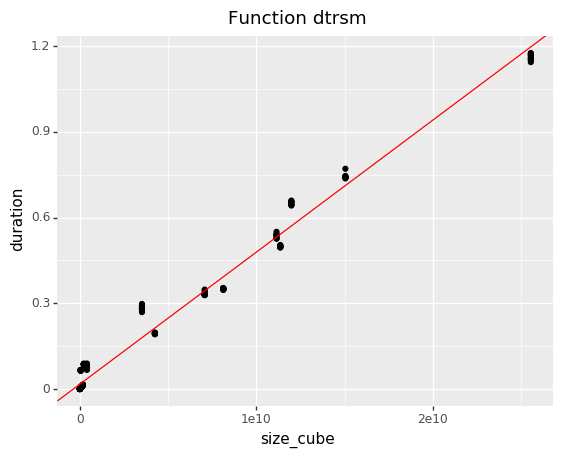

<ggplot: (8777356913903)>

In [14]:
tmp = get_op(result_monocore_contention, 'dtrsm')
tmp = tmp[(tmp.min_size <= 128) & (tmp.max_size > 2000)]
compute_lm(tmp)

intercept  : 3.739778e-04
coefficient: 8.286907e-11


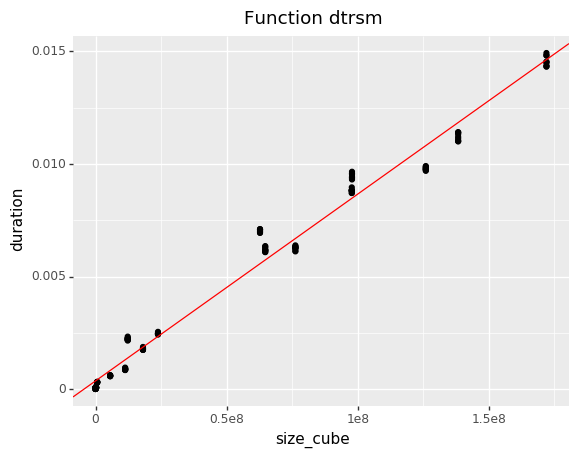

<ggplot: (8777356835364)>

In [15]:
tmp = get_op(result_monocore_contention, 'dtrsm')
tmp = tmp[tmp.n <= 128]
compute_lm(tmp)

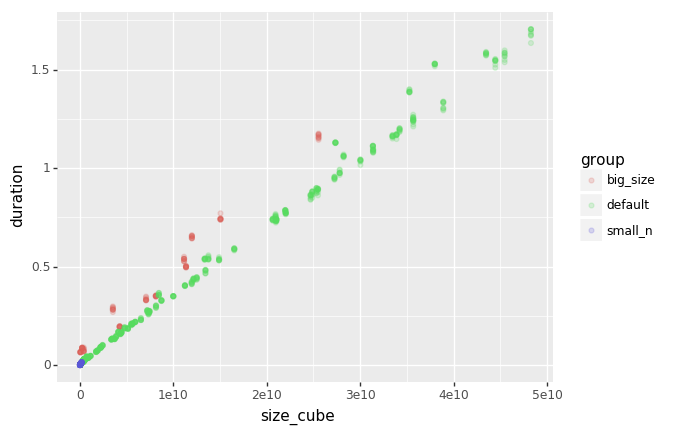

<ggplot: (-9223363259497880246)>


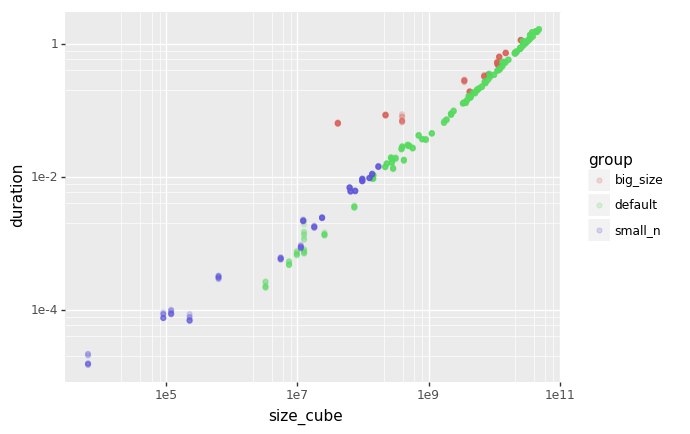

<ggplot: (-9223363259497713471)>


In [16]:
tmp = get_op(result_monocore_contention, 'dtrsm').copy()
tmp['group'] = 'default'
tmp.loc[(tmp.min_size <= 128) & (tmp.max_size > 2000), 'group'] = 'big_size'
tmp.loc[tmp.n <= 128, 'group'] = 'small_n'
plot = ggplot(tmp, aes(x='size_cube', y='duration', color='group')) + geom_point(alpha=0.2)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())